In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
from cmdstanpy import CmdStanModel
import arviz as az

if not os.path.exists('./stan'):
    os.makedirs('./stan')

c:\Users\matte\anaconda3\envs\stan\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_out120 = """

data {
  int<lower=0> N; // Number of observations
  int<lower=0> N_miss; // Number of missing observations
  int<lower=0> P; // Covariate number
  int<lower=0> nyears;
  int<lower=0> nstations;

  array[N] int<lower=0> station;
  array[N] int<lower=0> year;
  array[N] int<lower=0> max_month;

  array[N_miss] int<lower=0> station_miss;
  array[N_miss] int<lower=0> year_miss;
  array[N_miss] int<lower=0> max_month_miss;
  
  array[N] int<lower=0> y; // Count data

  matrix[N, P] X; // Predictor matrix
  matrix[N_miss, P] X_miss; // Predictor matrix

  real phi;
  matrix[nstations, nstations] distances;

  vector[N] dummy_luglio_obs;
  vector[N_miss] dummy_luglio_miss;
}

transformed data {
  matrix[nstations,nstations] H = exp(-(1/phi) * distances);
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nstations] eta; // Random effects for comuni
  vector[nyears] xi; // Random effects for years
  vector[nstations] w; //Random zero-mean effect for the space model
  real<lower = 0> sigma;
  real<lower = 0> sigma0;

  vector[nstations] dummy_beta;
  //vector[nyears] dummy_beta_y;
}

transformed parameters {
  vector[N] lambda;
  vector[N] fix_eff;
  vector[N] dummy_eff;
  //vector[N] dummy_eff_y;
  vector[N] intercept;

  vector[N_miss] lambda_miss;
  vector[N_miss] fix_eff_miss;
  vector[N_miss] dummy_eff_miss;
  //vector[N_miss] dummy_eff_y_miss;
  vector[N_miss] intercept_miss;

  matrix[nstations,nstations] Sigma_s = sigma * sigma * H; //To be added the variance
  matrix[nstations,nstations] Lw = cholesky_decompose(Sigma_s);


  fix_eff = X * beta;
  for (i in 1:N) {
    dummy_eff[i] = dummy_luglio_obs[i] * dummy_beta[station[i]]; // * dummy_beta_y[year[i]];
  }
  intercept = xi[year] + eta[station] + w[station] + dummy_eff;
  lambda = exp(fix_eff + intercept);

  fix_eff_miss = X_miss * beta;
  for (i in 1:N_miss) {
    dummy_eff_miss[i] = dummy_luglio_miss[i] * dummy_beta[station_miss[i]]; // * dummy_beta_y[year_miss[i]];
  }
  intercept_miss = xi[year_miss] + eta[station_miss] + w[station_miss] + dummy_eff_miss;
  lambda_miss = exp(fix_eff_miss + intercept_miss);

  /*
  for (i in 1:N) {
    if (lambda[i] > max_month[i]) {
      lambda[i] = max_month[i];
    }
  }

  for (i in 1:N_miss) {
    if (lambda_miss[i] > max_month_miss[i]) {
      lambda_miss[i] = max_month_miss[i];
    }
  }
  */
}

model {
  beta ~ normal(0, 2);
  for (i in 1:N) {
    y[i] ~ poisson(lambda[i]);
  };

  xi ~ normal(0, 2);
  eta ~ normal(0, sigma0);
  w ~ multi_normal_cholesky(rep_vector(0, nstations), Lw);
  sigma ~ inv_gamma(2, 2);
  sigma0 ~ inv_gamma(2, 2);

  dummy_beta ~ normal(-1, 2);
  //dummy_beta_y ~ normal(-1, 2);
}

generated quantities {
  vector[N] log_lik;
  vector[N] y_pred;
  vector[N_miss] y_pred_miss;

  for(i in 1:N) {
    log_lik [ i ] = poisson_lpmf (y[i] | lambda[i]);
  }

  /*
  for (i in 1:N) {
    real sum_p = 0;
    real u = uniform_rng(0, 1);
    for (b in 0:max_month[i]) {
      sum_p = sum_p + exp(poisson_lpmf(b | lambda[i]) - poisson_lcdf(max_month[i] | lambda[i]));
      if (sum_p >= u) {
        y_pred[i] = b;
        break;
      }
    }
  }
  */

  real y_temp;

  for(i in 1:N){
  y_temp = max_month[i] + 1;
    while (y_temp > max_month[i]) {
      y_temp = poisson_rng(lambda[i]);
    };
    y_pred[i] = y_temp;
  }

  for(i in 1:N_miss){
    y_temp = max_month_miss[i] + 1;
    while (y_temp > max_month_miss[i]){
      y_temp = poisson_rng(lambda_miss[i]);
    };
    y_pred_miss[i] = y_temp;
  }
  
  /*
  for (i in 1:N) {
   y_pred[i] = poisson_rng(lambda[i]);
  }

  for (i in 1:N_miss) {
    y_pred_miss[i] = poisson_rng(lambda_miss[i]);
  }
  */

  /*
  for (i in 1:N) {
    if (y_pred[i] > max_month[i]) {
      y_pred[i] = max_month[i];
    }
  }

  for (i in 1:N_miss) {
    if (y_pred_miss[i] > max_month_miss[i]) {
      y_pred_miss[i] = max_month_miss[i];
    }
  }
  */
}

"""

stan_file = "./stan/out120.stan"

with open(stan_file, "w") as f:
    print(model_out120, file=f)

model_out120 = CmdStanModel(stan_file=stan_file)

12:48:16 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\out120.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\out120.exe
12:49:15 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\out120.exe


In [3]:
X = pd.read_csv("../Datasets/covariates.csv")
Y = pd.read_csv("../Datasets/Dataset_120.csv")

Y.loc[:,'Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.get_dummies(X ,columns = ['Type'] ,prefix = 'type', drop_first = True)
X.loc[X['Station'] == 10171, 'Quota'] = 10

phi = 62/3
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [4]:
#adding repeated colums in the covariates
years_to_repeat = [2010, 2015, 2022]
station_to_repeat = [9991]
months_to_repeat = [7]

#X['temp_bis'] = 0.0
#X['prec_sum_bis'] = 0.0
#X['prec_hours_bis'] = 0.0
#X['rad_bis'] = 0.0
X['dummy_luglio'] = 0.0

#idx_to_repeat=np.where((X['Year'].isin(years_to_repeat)) | (X['Station'] == station_to_repeat) | (X['Month'] == months_to_repeat)) [0]
idx_to_repeat = np.where(X['Month'].isin(months_to_repeat))[0]
#X.loc[idx_to_repeat, 'temp_bis'] = X.loc[idx_to_repeat, 'mean_temperature']
#X.loc[idx_to_repeat, 'prec_sum_bis'] = X.loc[idx_to_repeat, 'mean_precipitation_sum']
#X.loc[idx_to_repeat, 'prec_hours_bis'] = X.loc[idx_to_repeat, 'mean_precipitation_hours']
#X.loc[idx_to_repeat, 'rad_bis'] = X.loc[idx_to_repeat, 'mean_radiation_sum']
X.loc[idx_to_repeat, 'dummy_luglio'] = np.ones(len(idx_to_repeat))

In [5]:
rows_to_drop_Y = Y[Y['Count_120'].isna()].index

# Remove corresponding rows from dataset X
X_obs = X.drop(index=rows_to_drop_Y)
Y_obs = Y.drop(index=rows_to_drop_Y)
X_miss = X.loc[rows_to_drop_Y,:]
Y_miss = Y.loc[rows_to_drop_Y,:]

#saving the indexes of the dataframes
X_obs_index = X_obs.index
Y_obs_index = Y_obs.index
X_miss_index = X_miss.index
Y_miss_index = Y_miss.index

# If you want to reset the index after dropping rows
X_obs = X_obs.reset_index(drop=True)
Y_obs = Y_obs.reset_index(drop=True)
X_miss = X_miss.reset_index(drop=True)
Y_miss = Y_miss.reset_index(drop=True)

In [6]:
stations_obs = X_obs.loc[:,'Station']
years_raw_obs = X_obs.loc[:,'Year']
months_raw_obs = X_obs.loc[:,'Month']
years_obs = X_obs.loc[:,'Year'] - 2009
unique_values_obs = sorted(set(stations_obs))
mapping_dict_obs = {value: index + 1 for index, value in enumerate(unique_values_obs)}
transformed_stations_obs = [mapping_dict_obs[value] for value in stations_obs]

transformed_stations_obs = pd.Series(transformed_stations_obs)
years_obs = pd.Series(years_obs)

stations_miss = X_miss.loc[:,'Station']
years_raw_miss = X_miss.loc[:,'Year']
months_raw_miss = X_miss.loc[:,'Month']
years_miss = X_miss.loc[:,'Year'] - 2009
unique_values_miss = sorted(set(stations_miss))
mapping_dict_miss = {value_miss: index_miss + 1 for index_miss, value_miss in enumerate(unique_values_miss)}
transformed_stations_miss = [mapping_dict_miss[value_miss] for value_miss in stations_miss]

transformed_stations_miss = pd.Series(transformed_stations_miss)
years_miss = pd.Series(years_miss)

day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month_obs = []
max_month_miss = []

for i in range(0,X_obs.shape[0]):
    max_month_obs.append(day_in_month[X_obs['Month'][i]-1])

for i in range(0,X_miss.shape[0]):
    max_month_miss.append(day_in_month[X_miss['Month'][i]-1])

max_month_obs = pd.Series(max_month_obs)
max_month_miss = pd.Series(max_month_miss)

dummy_luglio_obs = X_obs.loc[:,'dummy_luglio']
dummy_luglio_miss = X_miss.loc[:,'dummy_luglio']
dummy_luglio_obs = pd.Series(dummy_luglio_obs)
dummy_luglio_miss = pd.Series(dummy_luglio_miss)

In [7]:
X_obs = X_obs.drop(['Year','Station','Month', 'dummy_luglio'], axis  = 1)
X_miss = X_miss.drop(['Year','Station','Month', 'dummy_luglio'], axis  = 1)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_obs_std = scaler.fit_transform(X_obs)
X_obs_std = pd.DataFrame(X_obs_std, columns=X_obs.columns)
X_obs_std.loc[:,"type_rural"] = X.loc[:,"type_rural"]
X_obs_std.loc[:,"type_urban"] = X.loc[:,"type_urban"]
X_obs_std.loc[:,"type_rural"] = pd.to_numeric(X_obs_std.loc[:,"type_rural"]).astype('Int64')
X_obs_std.loc[:,"type_urban"] = pd.to_numeric(X_obs_std.loc[:,"type_urban"]).astype('Int64')

X_miss_std = scaler.fit_transform(X_miss)
X_miss_std = pd.DataFrame(X_miss_std, columns=X_miss.columns)
X_miss_std.loc[:,"type_rural"] = X_miss.loc[:,"type_rural"]
X_miss_std.loc[:,"type_urban"] = X_miss.loc[:,"type_urban"]
X_miss_std.loc[:,"type_rural"] = pd.to_numeric(X_miss_std.loc[:,"type_rural"]).astype('Int64')
X_miss_std.loc[:,"type_urban"] = pd.to_numeric(X_miss_std.loc[:,"type_urban"]).astype('Int64')

In [9]:
data_out120 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances,
    "dummy_luglio_obs": dummy_luglio_obs,
    "dummy_luglio_miss": dummy_luglio_miss
}

fit_out120 = model_out120.sample(data=data_out120, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_out120 = az.from_cmdstanpy(fit_out120)

12:49:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▊         | 00:00 Status
chain 1 |█▋        | 01:19 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 01:56 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 02:31 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 02:59 Iteration: 300 / 1000 [ 30%]  (Warmup)


chain 1 |█████▊    | 03:25 Iteration: 500 / 1000 [ 50%]  (Warmup)





chain 1 |██████▋   | 03:52 Iteration: 501 / 1000 [ 50%]  (Sampling)


chain 1 |███████▌  | 04:19 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████████▎ | 04:44 Iteration: 700 / 1000 [ 70%]  (Sampling)

chain 1 |█████████▏| 05:10 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 05:34 Iteration: 900 / 1000 [ 90%]  (Sampling)



chain 1 |██████████| 05:59 Sampling completed                      
chain 2 |██████████| 05:59 Sampling completed                      
chain 3 |██████████| 05:59 Sampling complete


12:55:15 - cmdstanpy - INFO - CmdStan done processing.
12:55:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: Matrix m is not positive definite (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, c

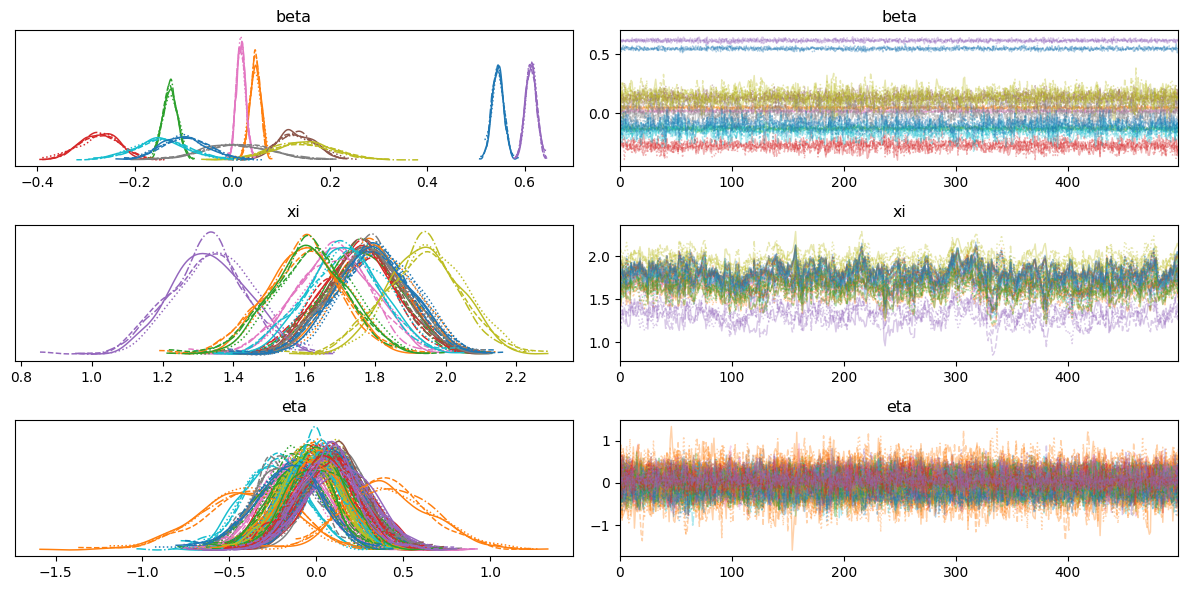

In [10]:
az.plot_trace(posterior_out120, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [11]:
posterior_out120

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

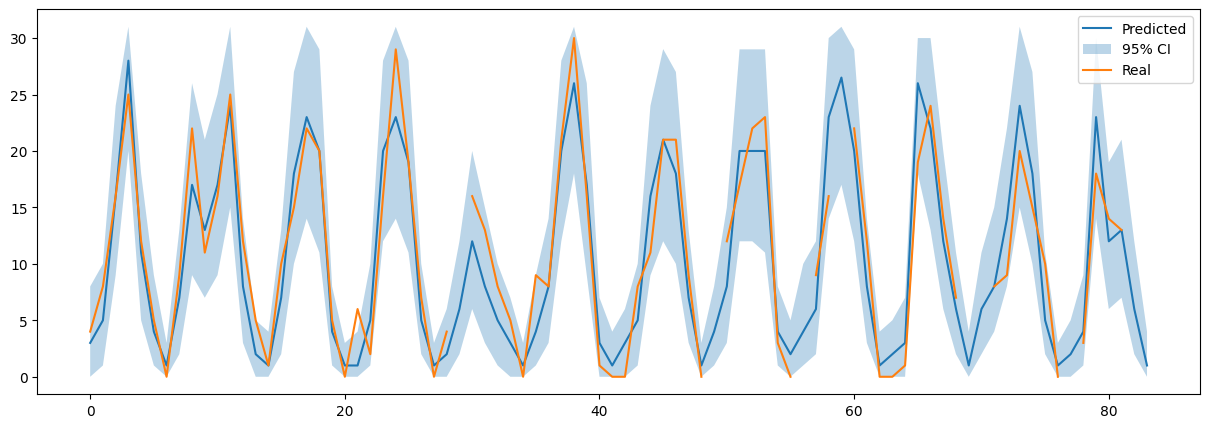

In [22]:
#preds_y = posterior_out120['posterior']['y_pred'].mean(axis=0)
#preds_y_miss = posterior_out120['posterior']['y_pred_miss'].mean(axis=0)

#y_star = preds_y.median(axis=0)
#y_star_up = np.ceil(np.percentile(preds_y, 97.5, axis=0))
#y_star_low = np.floor(np.percentile(preds_y, 2.5, axis=0))

#y_star_miss = preds_y_miss.median(axis=0)
#y_star_up_miss = np.ceil(np.percentile(preds_y_miss, 97.5, axis=0))
#y_star_low_miss = np.floor(np.percentile(preds_y_miss, 2.5, axis=0))

y_star = posterior_out120.posterior.y_pred.median(dim=["chain", "draw"])
y_star_up = posterior_out120.posterior.y_pred.quantile(q=0.975, dim=["chain", "draw"])
y_star_low = posterior_out120.posterior.y_pred.quantile(q=0.025, dim=["chain", "draw"])

y_star_miss = posterior_out120.posterior.y_pred_miss.median(dim=["chain", "draw"])
y_star_up_miss = posterior_out120.posterior.y_pred_miss.quantile(q=0.975, dim=["chain", "draw"])
y_star_low_miss = posterior_out120.posterior.y_pred_miss.quantile(q=0.025, dim=["chain", "draw"])

# Recunstruct the original indexes
y_star_obs = pd.Series(y_star, index=Y_obs_index)
y_star_up_obs = pd.Series(y_star_up, index=Y_obs_index)
y_star_low_obs = pd.Series(y_star_low, index=Y_obs_index)

y_star_miss = pd.Series(y_star_miss, index=Y_miss_index)
y_star_up_miss = pd.Series(y_star_up_miss, index=Y_miss_index)
y_star_low_miss = pd.Series(y_star_low_miss, index=Y_miss_index)

# Add the missing values
y_star_total = pd.concat([y_star_obs, y_star_miss])
y_star_up_total = pd.concat([y_star_up_obs, y_star_up_miss])
y_star_low_total = pd.concat([y_star_low_obs, y_star_low_miss])

# Sort the values
y_star_total = y_star_total.sort_index()
y_star_up_total = y_star_up_total.sort_index()
y_star_low_total = y_star_low_total.sort_index()

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_star_total[xx], label='Predicted')
plt.fill_between(xx, y_star_low_total[xx], y_star_up_total[xx], alpha=0.3, label='95% CI')
plt.plot(xx, Y_data[xx], label='Real')
plt.legend()
plt.show()


In [23]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers)
print(outliers.shape)

[  21   83  145  154  165  173  211  227  234  308  309  350  351  363
  385  391  394  396  404  410  413  414  420  422  423  429  430  433
  472  477  478  479  481  482  486  488  493  512  513  519  581  582
  585  588  599  609  618  643  648  650  662  665  669  682  685  690
  695  701  718  749  753  757  769  770  771  774  775  781  799  802
  807  824  835  863  864  869  874  876  877  884  898  901  917  918
  919  920  921  931  950  955  962  984 1016 1019 1021 1022 1026 1042
 1043 1053 1073 1105 1118 1146 1165 1179 1185 1195 1222 1255 1283 1329
 1331 1341 1371 1384 1385 1407 1408 1449 1527 1535 1540 1552 1553 1559
 1563 1591 1611 1631 1667 1765 1774 1786 1802 1824 1848 1859 1867 1869
 1874 1889 1897 1903 1911 1912 1923 1953 1955 1960 1978 1983 1989 2008
 2026 2029 2050 2075 2076 2089 2110 2115 2119 2127 2134 2137 2140 2144
 2180 2198 2221 2227 2233 2234 2238 2241 2250 2251 2291 2301 2315 2327
 2332 2363 2375 2382 2398 2399 2406 2430 2458 2460 2462 2464 2465 2503
 2546 

In [24]:
# printing the percentage of observation inside the interval
print(1 - outliers.shape[0]/Y_obs.shape[0])

0.91484375


[]
(0,)
[ 391  410  429  478  599  695  701  769  770  876  884  920  950 1016
 1021 1407 1408 1527 1889 1978 1983 2026 2119 2140 2251 2399 2718 2749
 2761 2832 2833 2988 3014 3028 3041 3095 3140 3161 3522 3526 3607 3694]
(42,)


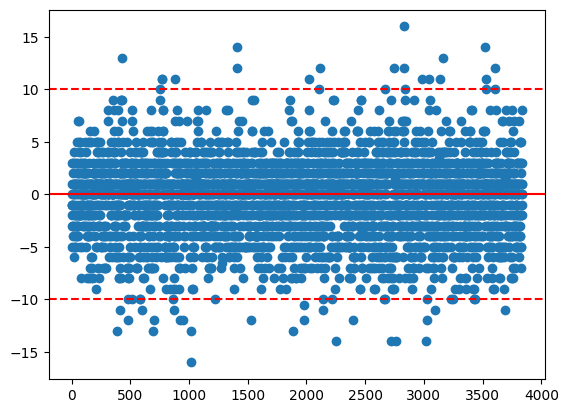

In [25]:
idx_over_max = np.where(y_star > max_month_obs)[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120']
residuals = np.abs(res)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [26]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

<xarray.DataArray ()>
array(2.68450521)
<xarray.DataArray ()>
array(12.8546224)


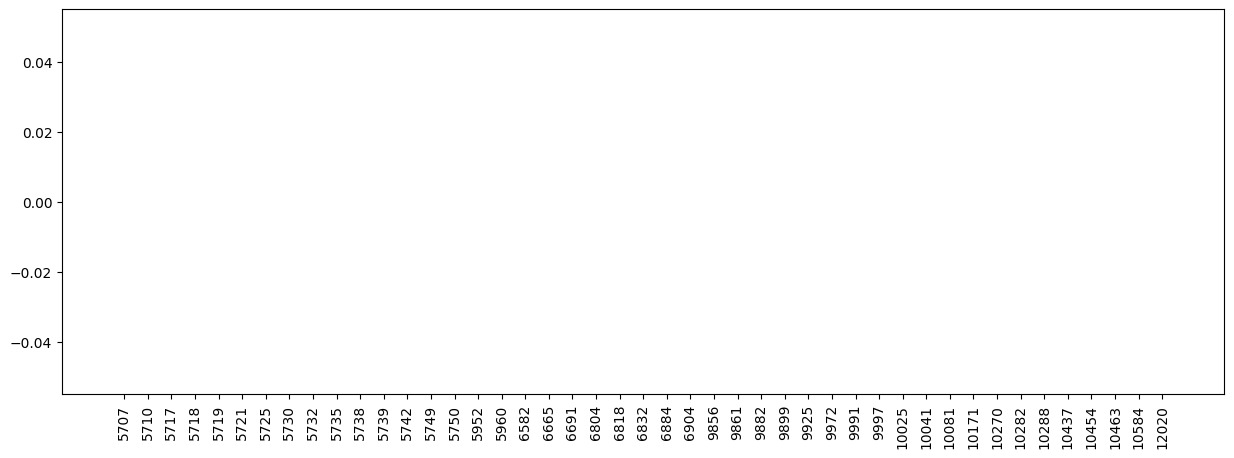

In [17]:
# Count how many outliers we have per station
outliers_per_station = pd.Series(np.zeros(45), index=stations_obs.unique())
for i in idx_over_max:
    outliers_per_station[stations_obs[i]] += 1
outliers_per_station = outliers_per_station.astype(int)
outliers_per_station.index = outliers_per_station.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_station.index, outliers_per_station)
plt.xticks(rotation=90)
plt.show()

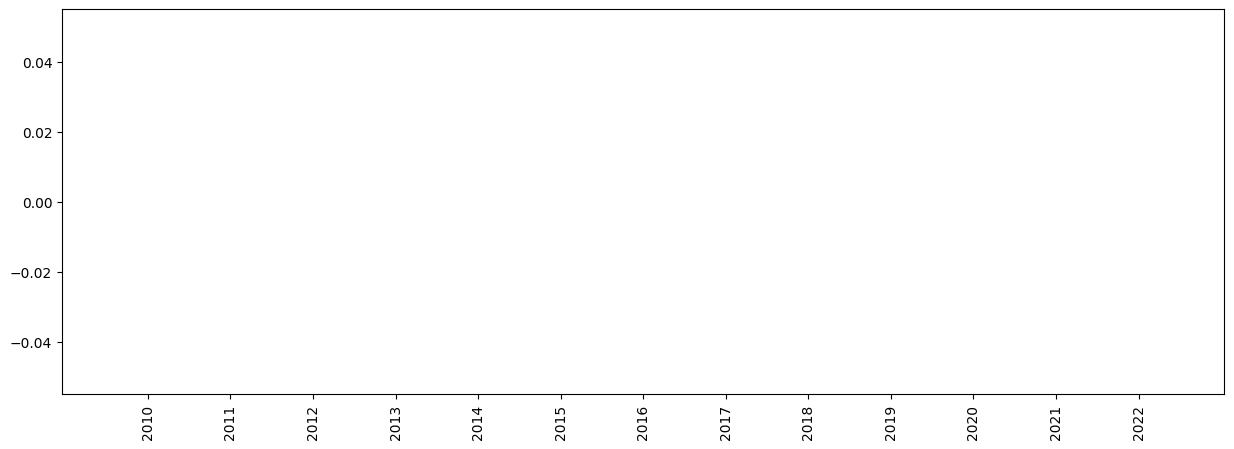

In [18]:
# Count how many outliers we have per year
outliers_per_year = pd.Series(np.zeros(13), index=years_raw_obs.unique())
for i in idx_over_max:
    outliers_per_year[years_raw_obs[i]] += 1
outliers_per_year = outliers_per_year.astype(int)
outliers_per_year.index = outliers_per_year.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_year.index, outliers_per_year)
plt.xticks(rotation=90)
plt.show()

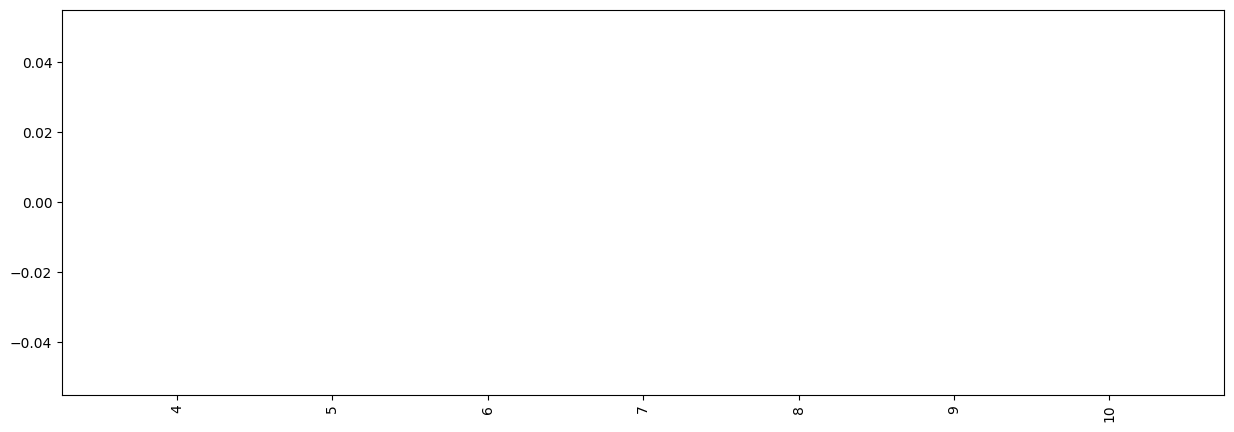

In [19]:
# Count how many outliers we have per month
outliers_per_month = pd.Series(np.zeros(7), index=months_raw_obs.unique())
for i in idx_over_max:
    outliers_per_month[months_raw_obs[i]] += 1
outliers_per_month = outliers_per_month.astype(int)
outliers_per_month.index = outliers_per_month.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_month.index, outliers_per_month)
plt.xticks(rotation=90)
plt.show()

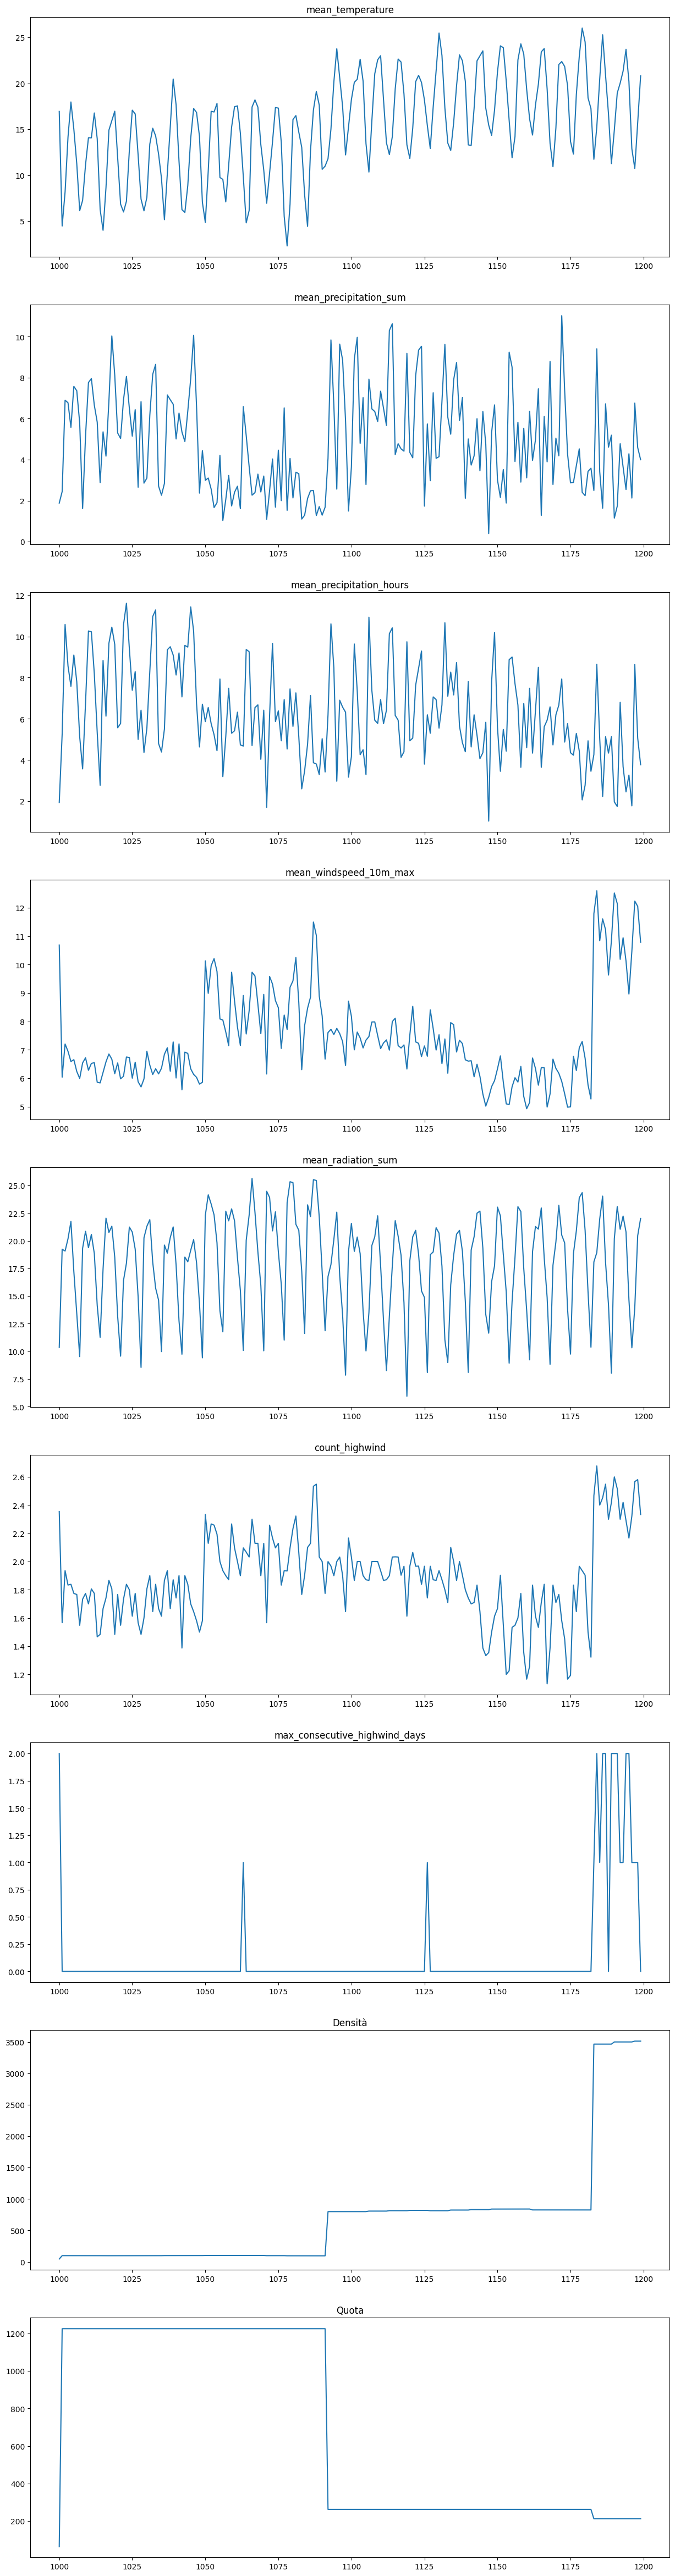

In [20]:
# Plotting covariates around the outliers
X_data = X.drop(['Year','Station','Month'], axis  = 1)
station_num_to_plot = -1 # Change this to plot different stations, -1 to choose manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
fig, axs = plt.subplots(9, 1, figsize=(15, 60))
for i in range(0,9): # i do not plot the repeated measures
    axs[i].plot(xx, X_data.iloc[:,i][xx])
    axs[i].scatter(np.intersect1d(X_obs_index[idx_over_max],xx), X_data.iloc[:,i][np.intersect1d(X_obs_index[idx_over_max],xx)], color='r')
    axs[i].set_title(X_data.columns[i])
plt.show()